In [2]:
import json
import string
import nltk
from itertools import islice
import pandas as pd


nltk.download('punkt')
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import numpy as np

[nltk_data] Downloading package punkt to /Users/yhkuo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yhkuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yhkuo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing functions

In [3]:
def tokenize(line):
    punct = set(string.punctuation)
    punct.update(['’','”','“','—'])
    token = word_tokenize(line)
    token = [''.join(c for c in s if c not in punct) for s in token]
    return token

def removeStopword(tokens):
    stopWords = set(stopwords.words('english'))
    return [ token.lower() for token in tokens if token.lower() not in stopWords ]

def lemmatize(tokens):
    return [ WordNetLemmatizer().lemmatize(token) for token in tokens ]

def preprocess(line):
    token = tokenize(line)
    token = removeStopword(token)
    lemmas = [ c for c in lemmatize(token) if c != '']
    return lemmas

In [4]:
def createFrequencyMatrix(lemmas):
    frequency_matrix = {}
    for i in range(len(lemmas)):
        sen = lemmas[i]
        for word in sen:
            if word in frequency_matrix:
                frequency_matrix[word] += 1
            else:
                frequency_matrix[word] = 1
    return  {k: v for k, v in sorted(frequency_matrix.items(), key=lambda item: item[1], reverse=True)}

In [5]:
dataPath = '../final-project/public/data/news.json'
with open(dataPath) as file:
    data = json.load(file)
    print(len(data))

2871


In [11]:
threshold = 1
for story in data:
    content = story['content']
    lemma = []
    for line in content:
        lemma.append(preprocess(line))
    fq = createFrequencyMatrix(lemma)
    
    wordcloud = []
    for key, value in fq.items():
        if value > 1:
            item = [key, value]
            wordcloud.append(item)
    
    
    story['wordcloud'] = wordcloud
    scope = list(filter(lambda x: x > 1, list(fq.values())))
    story['wordcloud_scope'] = {}
    if scope:
        story['wordcloud_scope']['Q3'] = int(np.quantile(scope, .75))
        story['wordcloud_scope']['Q2'] = int(np.quantile(scope, .50))
        story['wordcloud_scope']['Q1'] = int(np.quantile(scope, .25))
    

In [59]:
with open('../final-project/public/data/wordcloud.json', 'w') as file:
    json.dump(data, file)

## date subset

In [12]:
#"03/07/2020, 04:50:35"
date_encoding="%m/%d/%Y, %X"

In [13]:
date = "03/07/2020"

In [14]:
specific = []
for each in data:
    if date in each['time-stamp']:
        specific.append(each)

In [15]:
def mergeFrequencyMatrix(fq, wordcloud):
    for word, value in wordcloud:
        if word in fq:
            fq[word] += value
        else:
            fq[word] = value
    return fq
    #return  {k: v for k, v in sorted(frequency_matrix.items(), key=lambda item: item[1], reverse=True)}
def take(n, iterable):
    filtered = list(islice(iterable, n))
    return dict((x,y) for x,y in filtered)

In [16]:
fq = {}
for each in specific:
    fq = mergeFrequencyMatrix(fq, each['wordcloud'])
fq = {k: v for k, v in sorted(fq.items(), key=lambda item: item[1], reverse=True)}
fq = take(50, fq.items())
print(fq)

{'said': 2158, 'coronavirus': 1554, 'health': 1068, 'case': 982, 'state': 900, 'virus': 855, 'people': 851, 'friday': 761, 'official': 692, 'new': 647, 'outbreak': 637, 'week': 476, 'tested': 464, 'one': 452, 'positive': 422, 'would': 400, 'u': 397, 'patient': 393, 'two': 391, 'trump': 388, 'country': 377, 'spread': 374, 'public': 369, 'test': 368, 'home': 363, 'also': 346, 'according': 344, 'county': 331, 'thursday': 330, 'confirmed': 322, 'newsletter': 320, 'president': 313, 'ship': 309, 'china': 308, 'covid19': 306, 'employee': 303, 'reported': 302, 'resident': 296, 'news': 293, 'day': 291, 'first': 284, 'cruise': 276, 'work': 265, 'disease': 261, 'company': 258, 'travel': 253, 'told': 249, 'announced': 246, 'united': 244, 'worker': 241}


In [17]:
def quantile(fq):
    scope = list(filter(lambda x: x > 30, list(fq.values())))
    return int(np.quantile(scope, .75)), int(np.quantile(scope, .50)), int(np.quantile(scope, .25))
def DictToList(fq):
    fq_list = []
    for key, value in fq.items():
        item = [key, value]
        fq_list.append(item)
    return fq_list
def ListToDict(List):
    Dict = {}
    for key, value in List:
        Dict[key] = value
    return Dict

In [18]:
df = {}
df['wordcloud'] = DictToList(fq)
df['wordcloud_scope'] = {}
df['wordcloud_scope']['Q3'], df['wordcloud_scope']['Q2'], df['wordcloud_scope']['Q1'] = quantile(fq)

In [13]:
with open('../final-project/public/data/wordcloud_day.json', 'w') as file:
    json.dump(df, file)

## textRank

In [19]:
test = data[0]['content']
print(data[0]['time-stamp'])
print(data[0]['headline'])
content = ''
for line in test:
    line = line.strip()
    line = line.encode('ascii', 'ignore').decode('utf-8')
    content += line

03/07/2020, 04:50:35
9th coronavirus death reported in U.S. as virus continues to spread


In [20]:
def textRankPreprocessing(articles): #list of contents
    content = ''
    for article in articles:
        for line in article:
            line = line.strip()
            line = line.encode('ascii', 'ignore').decode('utf-8')
            content += line
    return content

In [21]:
from textRank import TextRank4Keyword

In [30]:
articles = []
for i in range(len(specific)):
    if i > 40: continue
    news = specific[i]
    articles.append(news['content'])
content = textRankPreprocessing(articles)

In [31]:
tr4w = TextRank4Keyword()
tr4w.analyze(content, candidate_pos = ['NOUN', 'PROPN'], window_size =4, lower=True)
result = tr4w.get_keywords(100)

In [32]:
amplified = []
for key, value in result:
    amplified.append([key, int(value*10)])
a_dict = ListToDict(amplified)
df = {}
df['wordcloud'] = amplified
df['wordcloud_scope'] = {}
df['wordcloud_scope']['Q3'], df['wordcloud_scope']['Q2'], df['wordcloud_scope']['Q1'] = quantile(a_dict)
print(df)

{'wordcloud': [['coronavirus', 301], ['health', 231], ['people', 174], ['virus', 169], ['state', 131], ['cases', 126], ['officials', 124], ['president', 120], ['trump', 110], ['new', 108], ['news', 104], ['city', 99], ['u.s.', 97], ['china', 94], ['friday', 89], ['patients', 83], ['york', 83], ['outbreak', 80], ['time', 80], ['hospital', 78], ['case', 77], ['monday', 72], ['university', 68], ['washington', 68], ['staff', 66], ['cdc', 63], ['disease', 62], ['world', 62], ['students', 61], ['covid-19', 61], ['country', 60], ['county', 59], ['number', 58], ['spread', 58], ['patient', 57], ['day', 56], ['days', 56], ['home', 56], ['dr.', 54], ['jorgensen', 54], ['tuesday', 54], ['italy', 53], ['man', 53], ['director', 52], ['department', 52], ['house', 52], ['week', 52], ['contact', 52], ['media', 51], ['countries', 51], ['emergency', 51], ['center', 50], ['person', 49], ['states', 49], ['ship', 49], ['travel', 49], ['government', 48], ['statement', 48], ['care', 47], ['employees', 45], ['

In [100]:
with open('../final-project/public/data/textrank.json', 'w') as file:
    json.dump(df, file)

## TFIDF

In [85]:
def merge_preprocess(article):
    content = ''
    for line in article:
        line = line.strip()
        line = line.encode('ascii', 'ignore').decode('utf-8')
        token = tokenize(line)
        token = removeStopword(token)
        lemmas = [ c for c in lemmatize(token) if c != '']
        text = ' '.join(lemmas)
        content += text
    return content

In [86]:
corpus = []
for each in specific:
    corpus.append(merge_preprocess(each['content']))

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
import re
stopWords = set(stopwords.words('english'))
cv=CountVectorizer(max_df=0.8,stop_words=stopWords, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

[Text(0, 0, 'said'),
 Text(0, 0, 'coronavirus'),
 Text(0, 0, 'health'),
 Text(0, 0, 'case'),
 Text(0, 0, 'state'),
 Text(0, 0, 'people'),
 Text(0, 0, 'virus'),
 Text(0, 0, 'friday'),
 Text(0, 0, 'official'),
 Text(0, 0, 'outbreak'),
 Text(0, 0, 'new'),
 Text(0, 0, 'tested'),
 Text(0, 0, 'positive'),
 Text(0, 0, 'one'),
 Text(0, 0, 'week'),
 Text(0, 0, 'would'),
 Text(0, 0, 'two'),
 Text(0, 0, 'spread'),
 Text(0, 0, 'public'),
 Text(0, 0, 'country')]

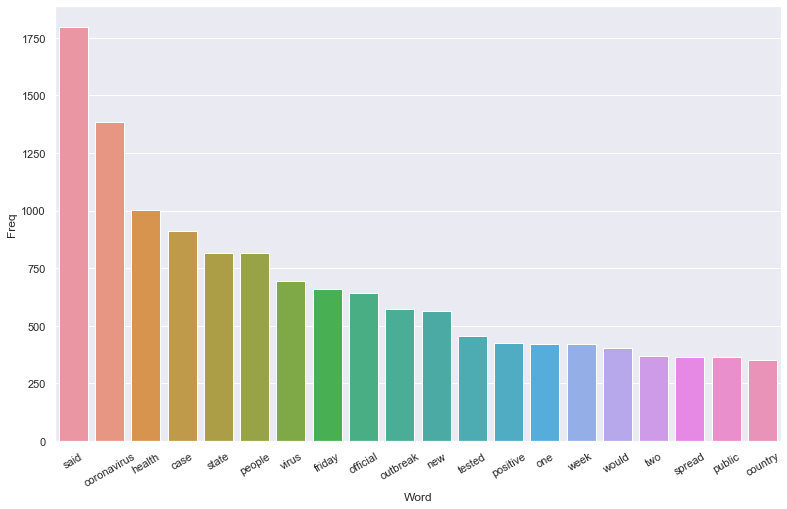

In [88]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

               Bi-gram  Freq
0      tested positive   260
1        public health   238
2             new york   207
3    novel coronavirus   207
4      health official   193
5         united state   186
6   coronavirus update   155
7    update newsletter   155
8     newsletter track   155
9       track outbreak   155
10      outbreak story   155
11        story linked   155
12     newsletter free   155
13       linked within   142
14   within newsletter   142
15     disease control   120
16         cruise ship   120
17      center disease   116
18         south korea   114
19      confirmed case   101


[Text(0, 0, 'tested positive'),
 Text(0, 0, 'public health'),
 Text(0, 0, 'new york'),
 Text(0, 0, 'novel coronavirus'),
 Text(0, 0, 'health official'),
 Text(0, 0, 'united state'),
 Text(0, 0, 'coronavirus update'),
 Text(0, 0, 'update newsletter'),
 Text(0, 0, 'newsletter track'),
 Text(0, 0, 'track outbreak'),
 Text(0, 0, 'outbreak story'),
 Text(0, 0, 'story linked'),
 Text(0, 0, 'newsletter free'),
 Text(0, 0, 'linked within'),
 Text(0, 0, 'within newsletter'),
 Text(0, 0, 'disease control'),
 Text(0, 0, 'cruise ship'),
 Text(0, 0, 'center disease'),
 Text(0, 0, 'south korea'),
 Text(0, 0, 'confirmed case')]

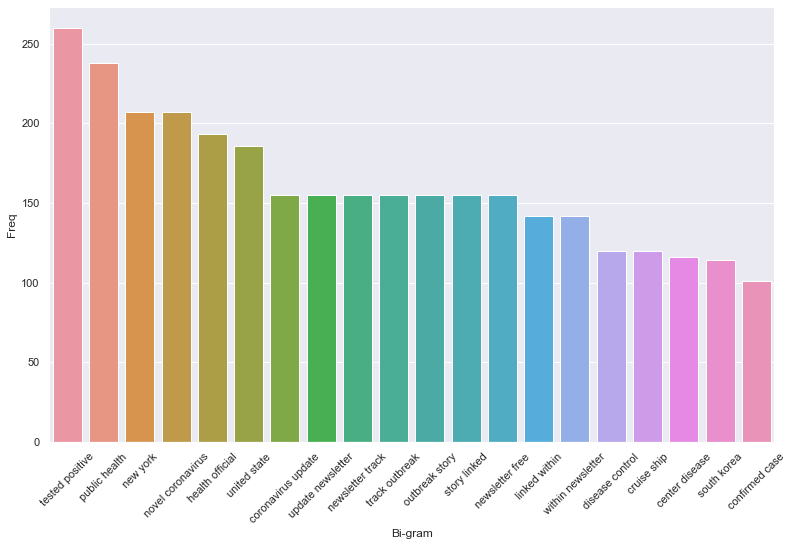

In [90]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                         Tri-gram  Freq
0   coronavirus update newsletter   155
1         update newsletter track   155
2       newsletter track outbreak   155
3            track outbreak story   155
4           outbreak story linked   155
5             story linked within   142
6        linked within newsletter   142
7          within newsletter free   142
8          center disease control   113
9      disease control prevention    82
10          tested positive virus    72
11                  new york city    46
12    tested positive coronavirus    44
13           said news conference    43
14           princess cruise ship    40
15      world health organization    36
16         covid19 disease caused    34
17         public health official    30
18                 new york state    29
19                  told abc news    27


[Text(0, 0, 'coronavirus update newsletter'),
 Text(0, 0, 'update newsletter track'),
 Text(0, 0, 'newsletter track outbreak'),
 Text(0, 0, 'track outbreak story'),
 Text(0, 0, 'outbreak story linked'),
 Text(0, 0, 'story linked within'),
 Text(0, 0, 'linked within newsletter'),
 Text(0, 0, 'within newsletter free'),
 Text(0, 0, 'center disease control'),
 Text(0, 0, 'disease control prevention'),
 Text(0, 0, 'tested positive virus'),
 Text(0, 0, 'new york city'),
 Text(0, 0, 'tested positive coronavirus'),
 Text(0, 0, 'said news conference'),
 Text(0, 0, 'princess cruise ship'),
 Text(0, 0, 'world health organization'),
 Text(0, 0, 'covid19 disease caused'),
 Text(0, 0, 'public health official'),
 Text(0, 0, 'new york state'),
 Text(0, 0, 'told abc news')]

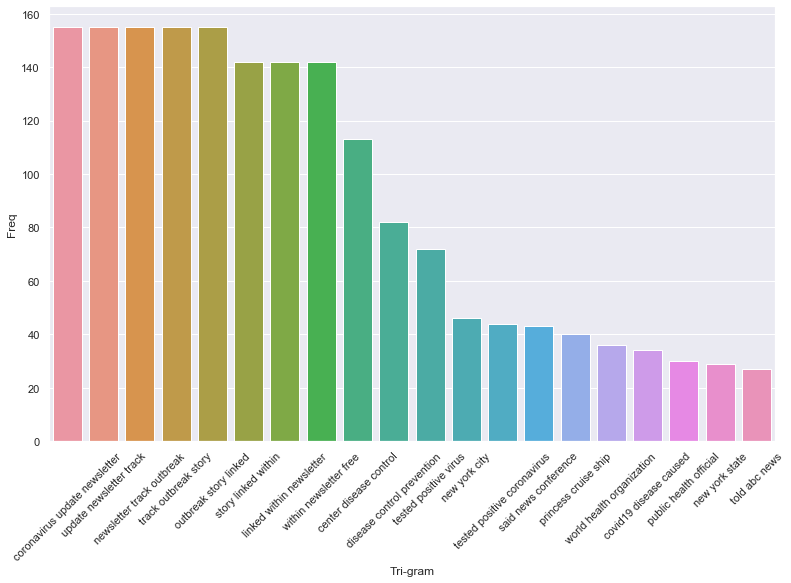

In [92]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

## RAKE

In [42]:
!pip3 install rake-nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7821 sha256=828cf7a740afce30bdc7c2e68072b3702bfbfc97f5e8685af63568f007cd4019
  Stored in directory: /Users/yhkuo/Library/Caches/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


In [52]:
from rake_nltk import Metric, Rake
r = Rake(max_length = 5)
r.extract_keywords_from_text(content)
r.get_ranked_phrases_with_scores()

[(23.25, 'imf managing director kristalina georgieva'),
 (22.666666666666664, 'general tedros adhanom ghebreyesus described'),
 (21.666666666666668, 'entire fleet every 72 hours'),
 (21.25, 'south korean president moon jae'),
 (20.87878787878788, 'fda commissioner stephen hahn said'),
 (20.666666666666668, 'attends salanter akiba riverdale academy'),
 (20.666666666666664, 'providers treating uninsured patients impacted'),
 (20.5, 'world bank president david malpass'),
 (20.0, 'diamond princess cruise ship quarantined'),
 (19.545454545454547, 'vice president mike pence said'),
 (19.52164502164502, 'ever done ," fauci said'),
 (19.5, 'prime minister boris johnson warned'),
 (19.416666666666664, 'past 24 hours -- 80'),
 (19.37878787878788, 'tsa administrator david pekoske said'),
 (19.36651583710407, 'health officials say vulnerable residents'),
 (19.272727272727273, 'two major international conferences scheduled'),
 (18.675, 'imf spokesperson told abc news'),
 (18.45475113122172, 'new ha